# Tunable First-Order Inexact Oracles :: Preliminary numerical tests

`Performance analysis of deterministic gradient based methods using accuracy global tunable inexact oracles.`

**Author** : *Guillaume Van Dessel*, Ph.D. candidate @EPL

**Comment** : For now on, let's stick to fully deterministic methods (however those might be inexact as well but there must be 
no source of randomness at each update step apart from oracle's content)

In [1]:
## packages' import
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import wald,norm,f,expon,chi2,uniform
import scipy.linalg as la
from IPython.display import display,clear_output
from ipywidgets import *
import decimal

%matplotlib notebook

np.warnings.filterwarnings('ignore')

____________________________________________________________________________________

Creation of a problem
-------------------------------

In [2]:
# @instantiation of the possibility lists 

# objective function list
obj_list = ['generic','other'] # add practical things

# method list
met_list = ['gd']

# inaccuracy level distribution list
dst_list = ['uniform','exponential','F','chi2','wald']

# search space dimension 
d = 10

#####################################################################################################################################

# @creation of inherent widgets

widget_obj = widgets.Dropdown(
    options=obj_list,
    value=obj_list[0],
    description='obj. fun.: ',
)

widget_met = widgets.Dropdown(
    options=met_list,
    value=met_list[0],
    description='method: ',
)

widget_dst = widgets.Dropdown(
    options=dst_list,
    value=dst_list[0],
    description='distrib. level: ',
)

widget_d = widgets.IntSlider(
    value=d,
    min=1,
    max=100,
    step=1,
    description='dimension:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

widget_cons = widgets.Checkbox(
    value=False,
    description='constrained?',
    disabled=False
)

widget_distance = BoundedFloatText(
    value=1,
    min=0,
    max=1000.0,
    step=0.05,
    description='center norm:',
    disabled=False)

In [3]:
# @default Problem class
class Problem:
    
    f = lambda x: (1/2)*np.sum(x**2)
    dif_f = lambda x: x
    mu = 1
    L = 1
    d = 10
    m = 0
    constr = False
    x_star = np.zeros(d)
    scale = 5
    center = None
    type_dom = None
    update = lambda h,u: u
    
    # instance based content yet to come
    
def short_not(float_number):
    return '%.3e' % decimal.Decimal(str(float_number))
    
def present_Problem():
    
    print(' ')
    print('|| problem summary ||')
    print('---------------------')
    print(' ')
    if Problem.constr:
        if Problem.type_dom is 'box':
            print('=> constrained in a box defined by :')
            if Problem.d <= 5:
                buf='['+short_not(Problem.center[0]-Problem.scale)+' , '+short_not(Problem.center[0]+Problem.scale)+']'
                for elem in np.linspace(1,Problem.d-1,Problem.d-1):
                    buf+=' X ['+short_not(Problem.center[int(elem)]-Problem.scale)+' , '\
                    +short_not(Problem.center[int(elem)]+Problem.scale)+']'
            else:
                buf = 'U from i = 1 to '+str(Problem.d)+' [c_i - '+str(Problem.scale)+' , c_i + '+str(Problem.scale)+']'
            print(buf)
        else:
            print('=> constrainted in a ball defined by : ')
            print(' B := {x in R^'+str(int(Problem.d))+' | ||x-c|| <= '+str(Problem.scale)+'}')
    else: 
        print('=> unconstrained ')
    print(' ')
    print('dimension : '+str(int(Problem.d)))
    print('estimated strong convexity parameter : '+str(Problem.mu))
    print('estimated smoothness parameter : '+str(Problem.L))
    print('activated constraints at optimum : '+str(int(Problem.m)))
    if Problem.d <= 20:
        print('optimum : '+str(Problem.x_star))
    print(' ')
    
def reset_Problem():
    
    Problem.f = lambda x: (1/2)*np.sum((x-Problem.x_star)**2)
    Problem.f = lambda x: (x-Problem.x_star)
    Problem.mu = 1
    Problem.L = 1
    Problem.d = 10

In [4]:
### models x_*
def free(dist):
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    Problem.x_star = dist*direc/la.norm(direc)
    
    Problem.center = Problem.x_star
    
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    
def ball_proj(u,center,scale):
    return center + (u-center)/np.max([scale,la.norm(u-center)])
    
def ball_constraint(center,m,scale):
    
    Problem.m = m
    Problem.scale = scale
    Problem.update = lambda h,u: ball_proj(u,Problem.center,Problem.scale)
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    
    if m==1:
        Problem.x_star = center+scale*direc/la.norm(direc)
    else:
        Problem.x_star = center+(scale*np.random.uniform(0,1)**(1/Problem.d))*direc/la.norm(direc)
        
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    
def box_proj(u,center,scale):
    buf = []
    bounds = [center-scale,center+scale]
    for j in np.arange(len(u)):
        if u[j]<bounds[0][j]:
            buf.append(bounds[0][j])
        elif u[j]>bounds[1][j]:
            buf.append(bounds[1][j])
        else:
            buf.append(u[j])
    return np.array(buf)
        
def box_constraint(center,m,scale):
    
    Problem.m = m
    Problem.scale = scale
    Problem.update = lambda h,u: box_proj(u,Problem.center,Problem.scale)
    
    bounds = [center-Problem.scale,center+Problem.scale]
    
    if m>0:
        indices = np.random.choice(np.arange(Problem.d),m,False)
        buf = np.zeros(Problem.d)
        for elem in np.arange(Problem.d):
            if elem in indices:
                buf[elem] = np.random.choice([bounds[0][elem],bounds[1][elem]],1)[0]
            else:
                buf[elem] = np.random.uniform(bounds[0][elem],bounds[1][elem],1)
        Problem.x_star = buf
    else:
        Problem.x_star = np.random.uniform(bounds[0],bounds[1],Problem.d)
        
    print(' ')
    print('=> a new optimizer has been chosen')
    if Problem.d <= 20:
        print(Problem.x_star)
    print(' ')
    
def constraint(dist,cstr_type='box'):
    
    direc = norm.rvs(loc=0, scale=1, size=Problem.d)
    cent = dist*direc/la.norm(direc)
    
    Problem.center = cent
    
    widget_scale = BoundedFloatText(
    value=1,
    min=0,
    max=1000.0,
    step=0.05,
    description='scale:',
    disabled=False)
    
    if cstr_type is 'ball':
        
        Problem.type_dom = 'ball'
    
        widget_m = widgets.IntSlider(
        value=0,
        min=0,
        max=1,
        step=1,
        description='number of activated constraints at x_*:')
        
        interact(lambda m,scale: ball_constraint(cent,m,scale),m=widget_m,scale=widget_scale)
    
    else:
        
        Problem.type_dom = 'box'
        
        widget_m = widgets.IntSlider(
        value=0,
        min=0,
        max=Problem.d,
        step=1,
        description='number of activated constraints at x_*:')
        
        interact(lambda m,scale: box_constraint(cent,m,scale),m=widget_m,scale=widget_scale)

In [5]:
### models for f and del f

# generic
def generic(alpha=1,beta=1.3,gamma=4.5):
    
    # @priori s.c. and smoothness parameters
    Problem.mu = alpha
    Problem.L = alpha + 4*beta + gamma/2 
    
    yf = widgets.HTMLMath(value=r'$$f(x) = \frac{\alpha}{2}\,||x-x_*||^2 + \beta \, g(x-x_*) + \gamma \, [h(x) - h(x_*) \
    - \langle \nabla h(x_*) \, , \, x-x_* \rangle] $$')
    ye = widgets.Label(value='where')
    yg = widgets.HTMLMath(value=r'$$g(x) = \frac{1}{2}\,[x_{1}^2 + \sum_{i=1}^{d}\, (x_{i} - x_{i+1})^2 + x_{d}^2]$$')
    yh = widgets.HTMLMath(value=r'$$h(x) = \log(\sum_{i=1}^{d} \, e^{x_{i}})$$')
    display(yf,ye,yg,yh)
    
    def z(x):
        return (1/2)*np.sum(x**2)
    
    def grad_z(x):
        return x
    
    def g(x):
        return (1/2)*(x[0]**2 + x[-1]**2 + np.sum((x[:-1]-x[1:])**2))
    
    def grad_g(x):
        zer = np.zeros(1)
        _x = np.concatenate((zer,x[:-1]),axis=None)
        x_ = np.concatenate((x[1:],zer),axis=None)
        return 2*x - (_x + x_)
    
    def h(x):
        delta = np.max(x)
        return delta + np.log(np.sum(np.exp(x-delta)))
    
    def grad_h(x):
        delta = np.max(x)
        u = np.exp(x-delta)
        return u/np.sum(u)
    
    x_star = Problem.x_star
    h_star = h(x_star)
    grad_h_star = grad_h(x_star)
    
    # first order information
    
    Problem.f = lambda x: alpha*z(x-x_star) + beta*g(x-x_star) +\
            gamma*(h(x)-h_star-(grad_h_star@(x-x_star)))
    
    Problem.dif_f = lambda x: alpha*grad_z(x-x_star) + beta*grad_g(x-x_star)+\
            gamma*(grad_h(x)-grad_h_star)

In [6]:
def change_optimizer(dimension,boolean,distance=5):
    
    Problem.d = int(dimension)
    Problem.constr = boolean
    
    if boolean: # only box, ball
        
        widget_type = widgets.Dropdown(
        options=['box','ball'],
        value='box',
        description='constraint type: ')
        
        interact(lambda cstr_type: constraint(distance,cstr_type), cstr_type = widget_type)
        
    else:
        
        free(distance)
        

def change_obj(string):
    
    if string is 'generic':
        
        widget_alpha = BoundedFloatText(
            value=1.0,
            min=0,
            max=100.0,
            step=0.01,
            description='alpha:',
            disabled=False)
        
        widget_beta = BoundedFloatText(
            value=1.3,
            min=0,
            max=100000.0,
            step=0.05,
            description='beta:',
            disabled=False)
        
        widget_gamma = BoundedFloatText(
            value=4.5,
            min=0,
            max=500000.0,
            step=0.5,
            description='gamma:',
            disabled=False)
        
        # exact f,dif functions 
        interact(generic,alpha = widget_alpha,beta = widget_beta, gamma = widget_gamma);
        
    else:
        
        # default f,dif functions 
        reset_Problem()
        y = widgets.HTMLMath(value=r'$$f(x) = \frac{||x-x_*||^2}{2}$$')
        display(y)

In [7]:
# optimum 
interact(change_optimizer,dimension = widget_d,boolean = widget_cons, distance = widget_distance);

interactive(children=(IntSlider(value=10, continuous_update=False, description='dimension:', min=1), Checkbox(…

In [8]:
# objective function
interact(change_obj,string = widget_obj);

interactive(children=(Dropdown(description='obj. fun.: ', options=('generic', 'other'), value='generic'), Outp…

In [9]:
button = widgets.Button(description="Load Problem")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        clear_output()
        present_Problem()

button.on_click(on_button_clicked)

Button(description='Load Problem', style=ButtonStyle())

Output()

basic $d_p = 1$ cost models
------------------------------------------------------

for all $k \in \{0,...,N-1\}$,

 (i)$$ \mathcal{M}(\eta_k) \propto K + \frac{\beta}{(\eta_k)^r}$$
 (ii) $$ \mathcal{M}(\eta_k) \propto K - \beta \log(\eta_k) $$

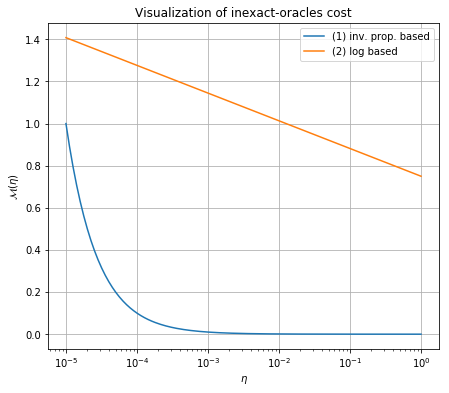

In [10]:
# c1 < c3*c2 to avoid convexity issues in (c1*delta + c2)/(1+c3*delta)
scaler_i = 1e-8
scaler_ii = 0.75
r = 1
K = 1
l = 2e-6
l_exp = int(np.log10(l))
beta_i = 1e3
beta_ii = 1/np.log(1/l)


def base_cost_i(eta):
    return scaler_i*(K+beta_i/(eta)**r)

def total_cost_i(etas):
    return scaler_i*(len(etas)*K + beta_i*np.sum(1/(+etas)**r))

def diff_total_cost_i(etas):
    return scaler_i*(-r*beta_i/(etas)**(r+1))

def base_cost_ii(eta):
    return scaler_ii*(K-beta_ii*np.log(eta))

def total_cost_i(etas):
    return scaler_ii*(len(etas)*K - beta_ii*np.sum(np.log(etas)))

def diff_total_cost_i(etas):
    return scaler_ii*(-beta_ii/(etas))


etas = np.logspace(l_exp,0,200)
plt.figure(figsize=(7,6))
plt.title('Visualization of inexact-oracle''s cost')
plt.xlabel('$\eta$')
plt.ylabel('$\mathcal{M}(\eta)$')
plt.grid()
plt.semilogx(etas,base_cost_i(etas))
plt.semilogx(etas,base_cost_ii(etas))
plt.legend(['(1) inv. prop. based','(2) log based']);
plt.savefig('costs.pdf')

basic $d_p = 1$ delta models
------------------------------------------------------


 (j)$$ \delta(\eta_k) \propto \frac{\eta_k^j}{j}$$
 
 **DO NOT FORGET THAT $\ell \succeq \mathbf{0}$** => convexity ensured

In [11]:
j = 2
mult_i = 3
mult_ii = (2*Problem.L + Problem.mu)/(Problem.L*Problem.mu) # Problem.mu should be strictly positive

def delta_i(eta):
    return mult_i*eta**j / j

def delta_ii(eta):
    return mult_ii*e**j / j

### Easy-to-go results 

Using *Devolder* type first-order tunable inexact oracles with fixed $\mu \leq L$, i.e. $\mathcal{T}_k = (\delta(\eta_k),L,\mu)$, $\forall k \in \{0,\dots,N-1\}$, one can show that 

$$ f(\hat{x}_N) - f^* \leq \frac{LR^2 \gamma_N}{2 W_N} + \frac{\sum_{k=0}^{N-1} w_k\, \delta(\eta_k)}{W_N}$$

where the coefficients $\gamma_N$, $\{w_k\}_{k=0}^{N-1}$ and $W_N$ are defined for every $N \in \mathbb{N}$ as in the following table.

<table>
    <tr>
        <td>
\begin{eqnarray}
          & & \gamma_N & w_k & W_{N} \\
     -----& -----|& ------& ------& -----\\
\text{GD} & & \rho^N & \rho^{N-1-k} & \sum_{k=0}^{N-1} \rho^{N-1-k} \\
\text{FGD} & & 1 & A_k & A_{N-1} \\
\end{eqnarray}
        </td>
    </tr>
</table>

where $A_i = \sum_{k=0}^i \alpha_k$ for which a reccurence is set up : $\alpha_0 = 1, \hspace{2pt} L+\mu\,A_k = \frac{L\alpha_{k+1}^2}{A_{k+1}}$ and $\rho = (1-\frac{\mu}{L})$.

KKT - conditions solved for $d_p=1$ at given $N$
-------------------------------------------------------

In [12]:
#  gamma_N / w_k / W_N (+ alpha_k in full mode turned on True and in 'FGD')

def compute_serial_coeffs(N=100,L=4,mu=0.01,mode = 'GD', full=False):
    if mode=='FGD':
        a_0 = 1 # shouldn't be changed
        a_list = [a_0]
        A = a_0
        A_list = [a_0]
        for k in np.arange(1,N):
            base = (L+mu*A)/L 
            buf = (base+np.sqrt(base**2 + 4*base*A))/2
            a_list.append(buf)
            A += buf
            A_list.append(A)
        ret = np.array(A_list)
        if full:
            return 1,ret,ret[-1],np.array(a_list)
        else:
            return 1,ret,ret[-1]
    else:
        N_list = np.arange(N)
        rho = (1-mu/L)
        ret = rho**(N-1-N_list)
        return rho**N,ret,np.sum(ret)

## experiment for $\tilde{\lambda}_0$

In [13]:
def experiment_i(N=1400,L=10,mu=0.1,mode='GD',epsilon=1e-5,R=10,j=1,q=3,r=1,l=2e-6,beta=1e3):
    N_list = np.arange(N+1)
    delta_fun = lambda eta: (q/j)*eta**(j)
    gamma_N,w_k,W_N = compute_serial_coeffs(N,L,mu,mode)
    Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
    check_feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(l) >= 0) # check feasibility
    if check_feas==False:
        print(' => error infeasible || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(l) = '+str(np.sum(w_k)*delta_fun(l)))
    else: # lin-search
        print(' => experiment started || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(l) = '+str(np.sum(w_k)*delta_fun(l)))
        list_lambda_0_tilde = []
        list_lambda_0_tilde_ok = []
        N_list_ok = []
        counter_ok = 0
        for elem in N_list:
            N_tilde_hat = int(elem)
            kappa = (beta*r)**(j/(j+r)) /j * np.sum((q*w_k[:N_tilde_hat])**(r/(j+r))) # should be >= 0
            Upsilon = Gamma_N_eps - delta_fun(l)*np.sum(w_k[N_tilde_hat:]) 
            lambda_0_tilde_hat = (kappa/Upsilon)**((j+r)/j)
            list_lambda_0_tilde.append(lambda_0_tilde_hat)
            feas = ((beta*r)/(q*w_k[N_tilde_hat-1]*l**(r+j))>lambda_0_tilde_hat)
            if N_tilde_hat <  N:
                feas =  feas and ((beta*r)/(q*w_k[N_tilde_hat]*l**(r+j))<=lambda_0_tilde_hat)   
            if feas:
                N_list_ok.append(N_tilde_hat)
                list_lambda_0_tilde_ok.append(lambda_0_tilde_hat)
                counter_ok+=1
        
        print(' => '+str(counter_ok)+' lambda_0''s optimal')
        plt.figure(figsize=(7,6))
        plt.title('Visualization of $\lambda_0$ with $\hat{N}$')
        plt.xlabel('$\hat{N}$')
        plt.ylabel('$\lambda_0$')
        plt.grid()
        plt.scatter(N_list,np.array(list_lambda_0_tilde),s=2.5)
        plt.scatter(np.array(N_list_ok),np.array(list_lambda_0_tilde_ok),color='orange')
        plt.legend(['$\lambda_0$','$\lambda_0^*$']);
        plt.savefig('lambdas1.pdf')
        
        plt.figure(figsize=(7,6))
        plt.title('Visualization of $\lambda_0$ with $\hat{N}$')
        plt.xlabel('$\hat{N}$')
        plt.ylabel('$\lambda_0$')
        plt.grid()
        plt.semilogy(N_list,np.array(list_lambda_0_tilde))
        plt.scatter(np.array(N_list_ok),np.array(list_lambda_0_tilde_ok),color='orange')
        plt.legend(['$\lambda_0$','$\lambda_0^*$']);
        plt.savefig('lambdas2.pdf')

 => experiment started || Gamma_N_eps = 33.318958211003746 , (sum_k w_k) delta(l) = 31.734746560070334
 => 1 lambda_0s optimal


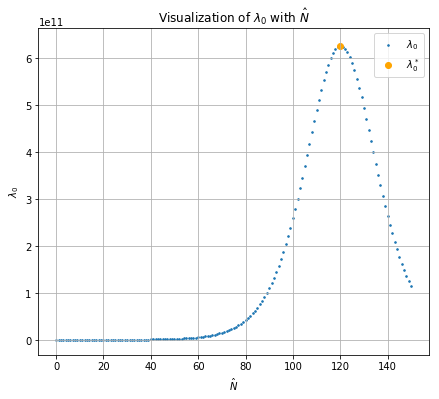

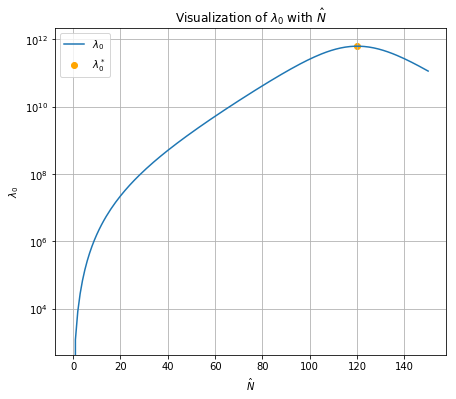

In [14]:
experiment_i(N=150,L=10,mu=0.1,epsilon=0.53e-5,mode='FGD',l=1e-8)

In [15]:
tolerance = 1e-16

# KKT (i) in O(N)

def KKT_i(N=1400,L=10,mu=0.1,mode='GD',epsilon=1e-5,R=10,j=1,q=3,r=1,l=2e-6,beta=1e3,K=1,verbose_check=False,mute=False,extr=False):
    N_tilde_upper = int(N)
    delta_fun = lambda eta: (q/j)*eta**(j)
    cost_fun = lambda etas: N*K + beta*np.sum(1/(etas**r))
    gamma_N,w_k,W_N = compute_serial_coeffs(N,L,mu,mode)
    Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
    check_feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(l) >= 0) # check feasibility
    if check_feas==False:
        if mute:
            print(' => error infeasible || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(l) = '+str(np.sum(w_k)*delta_fun(l)))
        return None,None,None,None
    else: # lin-search
        if mute:
            print(' => lin-search started || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(l) = '+str(np.sum(w_k)*delta_fun(l)))
        while N_tilde_upper>0:
            N_tilde_hat = int(N_tilde_upper)
            if verbose_check:
                print('current N_tilde_hat : '+str(N_tilde_hat))
            kappa = (beta*r)**(j/(j+r)) /j * np.sum((q*w_k[:N_tilde_hat])**(r/(j+r))) # should be >= 0
            Upsilon = Gamma_N_eps - delta_fun(l)*np.sum(w_k[N_tilde_hat:]) 
            if Upsilon > 0: # should always be ok
                lambda_0_tilde_hat = (kappa/Upsilon)**((j+r)/j) 
                feas = ((beta*r)/(q*w_k[N_tilde_hat-1]*l**(r+j))>lambda_0_tilde_hat)
                if N_tilde_hat <  N:
                    feas =  feas and ((beta*r)/(q*w_k[N_tilde_hat]*l**(r+j))<=lambda_0_tilde_hat)   
                if feas==False:
                    N_tilde_upper-=1
                else:
                    if mute:
                        print(' optimality reached at N_tilde = '+str(N_tilde_hat))
                    N_tilde_upper = 0 # exit
            else:
                print('-> check Slater assumption at first <-')
        if N_tilde_hat==0:
            opt_etas = l*np.ones(N)
        else:
            opt_etas = np.concatenate(((r*beta/(w_k[:N_tilde_hat]*q*lambda_0_tilde_hat))**(1/(j+r)),l*np.ones(int(N-N_tilde_hat))),axis=0)        
            if mute:
                print('active constraint up to tolerance => '+str(np.abs(Gamma_N_eps - np.sum(w_k*delta_fun(opt_etas)))<=tolerance))
        if extr==False:
            return opt_etas,cost_fun(opt_etas)
        else:
            eta_constant = (Gamma_N_eps*j/(q*np.sum(w_k)))**(1/j)
            if mute:
                print(eta_constant)
            return opt_etas,cost_fun(opt_etas),cost_fun(l*np.ones(N)),cost_fun(eta_constant*np.ones(N))

In [16]:
arg1,arg2,arg3,arg4 = KKT_i(N=144,L=10,mu=0.1,epsilon=1e-5,mode='FGD',l=1e-8,extr=True);

In [17]:
def experiment_ii(N=1400,L=10,mu=0.1,mode='GD',epsilon=1e-5,R=10,j=1,q=3,l=2e-6,beta=1e3):
    N_list = np.arange(N+1)
    delta_fun = lambda eta: (q/j)*eta**(j)
    gamma_N,w_k,W_N = compute_serial_coeffs(N,L,mu,mode)
    Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
    check_feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(l) >= 0) # check feasibility
    if check_feas==False:
        print(' => error infeasible || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(l) = '+str(np.sum(w_k)*delta_fun(l)))
    else: # lin-search
        print(' => experiment started || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(l) = '+str(np.sum(w_k)*delta_fun(l)))
        list_lambda_0_tilde = []
        list_lambda_0_tilde_ok = []
        N_list_ok = []
        counter_ok = 0
        for elem in N_list:
            N_tilde_hat = int(elem)
            kappa = N_tilde_hat*beta # should be >= 0
            Upsilon = Gamma_N_eps - delta_fun(l)*np.sum(w_k[N_tilde_hat:]) 
            lambda_0_tilde_hat = (kappa/Upsilon)
            list_lambda_0_tilde.append(lambda_0_tilde_hat)
            feas = ((beta)/(q*w_k[N_tilde_hat-1]*l**(j))>lambda_0_tilde_hat)
            if N_tilde_hat <  N:
                feas =  feas and ((beta)/(q*w_k[N_tilde_hat]*l**(j))<=lambda_0_tilde_hat)   
            if feas:
                N_list_ok.append(N_tilde_hat)
                list_lambda_0_tilde_ok.append(lambda_0_tilde_hat)
                counter_ok+=1
        
        print(' => '+str(counter_ok)+' lambda_0''s optimal')
        plt.figure(figsize=(7,6))
        plt.title('(GD) Visualization of $\lambda_0$ with $N_{tilde}$')
        plt.xlabel('$N_{tilde}$')
        plt.ylabel('$\lambda_0$')
        plt.grid()
        plt.scatter(N_list,np.array(list_lambda_0_tilde),s=2.5)
        plt.scatter(np.array(N_list_ok),np.array(list_lambda_0_tilde_ok),color='orange')
        plt.legend(['$\lambda_0$','$\lambda_0^*$']);
        plt.savefig('lambdas11.pdf')
        plt.savefig('lambdas11.svg')
        
        plt.figure(figsize=(7,6))
        plt.title('Visualization of $\lambda_0$ with $\hat{N}$')
        plt.xlabel('$\hat{N}$')
        plt.ylabel('$\lambda_0$')
        plt.grid()
        plt.semilogy(N_list,np.array(list_lambda_0_tilde))
        plt.scatter(np.array(N_list_ok),np.array(list_lambda_0_tilde_ok),color='orange')
        plt.legend(['$\lambda_0$','$\lambda_0^*$']);
        plt.savefig('lambdas22.pdf')

 => experiment started || Gamma_N_eps = 0.0006125253367546384 , (sum_k w_k) delta(l) = 0.0005999995350313335
 => 1 lambda_0s optimal


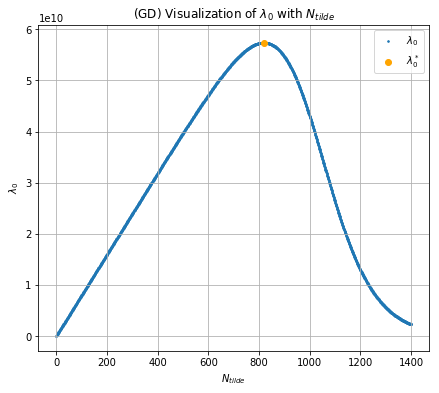

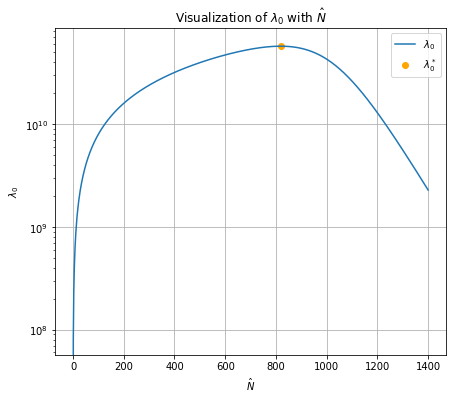

In [18]:
experiment_ii(N=1400,L=10,mu=0.1,epsilon=1e-5,mode='GD',l=2e-6);

In [19]:
tolerance = 1e-16

# KKT (i) in O(N)

def KKT_ii(N=1400,L=10,mu=0.1,mode='GD',epsilon=1e-5,R=10,j=1,q=3,l=2e-6,beta=1e3,K=1,verbose_check=False,mute=False,extr=False):
    N_tilde_upper = int(N)
    delta_fun = lambda eta: (q/j)*eta**(j)
    cost_fun = lambda etas: N*K + beta*np.sum(np.log(1/(etas)))
    gamma_N,w_k,W_N = compute_serial_coeffs(N,L,mu,mode)
    Gamma_N_eps = W_N*epsilon - (gamma_N*L*R**2)/2
    check_feas = (Gamma_N_eps - np.sum(w_k)*delta_fun(l) >= 0) # check feasibility
    if check_feas==False:
        if mute:
            print(' => error infeasible || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(l) = '+str(np.sum(w_k)*delta_fun(l)))
        return None,None,None,None
    else: # lin-search
        if mute:
            print(' => lin-search started || '+'Gamma_N_eps = '+str(Gamma_N_eps)+' , (sum_k w_k) delta(l) = '+str(np.sum(w_k)*delta_fun(l)))
        while N_tilde_upper>0:
            N_tilde_hat = int(N_tilde_upper)
            if verbose_check:
                print('current N_tilde_hat : '+str(N_tilde_hat))
            kappa = N_tilde_hat*beta # should be >= 0
            Upsilon = Gamma_N_eps - delta_fun(l)*np.sum(w_k[N_tilde_hat:]) 
            if Upsilon > 0: # should always be ok
                lambda_0_tilde_hat = (kappa/Upsilon)
                feas = (beta/(q*w_k[N_tilde_hat-1]*l**(j))>lambda_0_tilde_hat)
                if N_tilde_hat <  N:
                    feas =  feas and ((beta)/(q*w_k[N_tilde_hat]*l**(j))<=lambda_0_tilde_hat)   
                if feas==False:
                    N_tilde_upper-=1
                else:
                    if mute:
                        print(' optimality reached at N_tilde = '+str(N_tilde_hat))
                    N_tilde_upper = 0 # exit
            else:
                print('-> check Slater assumption at first <-')
        if N_tilde_hat==0:
            opt_etas = l*np.ones(N)
        else:
            opt_etas = np.concatenate(((beta/(w_k[:N_tilde_hat]*q*lambda_0_tilde_hat))**(1/(j)),l*np.ones(int(N-N_tilde_hat))),axis=0)        
            if mute:
                print('active constraint up to tolerance => '+str(np.abs(Gamma_N_eps - np.sum(w_k*delta_fun(opt_etas)))<=tolerance))
        if extr==False:
            return opt_etas,cost_fun(opt_etas)
        else:
            eta_constant = (Gamma_N_eps*j/(q*np.sum(w_k)))**(1/j)
            if mute:
                print(eta_constant)
            return opt_etas,cost_fun(opt_etas),cost_fun(l*np.ones(N)),cost_fun(eta_constant*np.ones(N))

In [20]:
KKT_ii(N=1083,L=10,mu=0.1,epsilon=1e-4,mode='GD',l=2e-6);

In [21]:
# parameters of interest 

mode_test = 'FGD'

if mode_test=='GD':
    N_test=1400 
    L_test=10
    mu_test=0.1
    epsilon_test = 1.5e-5
    r_test= 1
    N_test_min = 1083
    N_test_max = 2*N_test_min
    epsilon_test2 = 1e-4
    epsilon_test3 = 2e-4
    epsilon_hard = 1e-5
    l_test = 2e-6
else:
    N_test = 150
    L_test = 10
    mu_test = 0.1
    epsilon_test = 0.55e-5
    l_test = 1e-8
    r_test = 1
    N_test_min = 144
    N_test_max = 2*N_test_min
    epsilon_test2 = 1e-5
    epsilon_test3 = 2e-5
    epsilon_hard = 0.53e-5

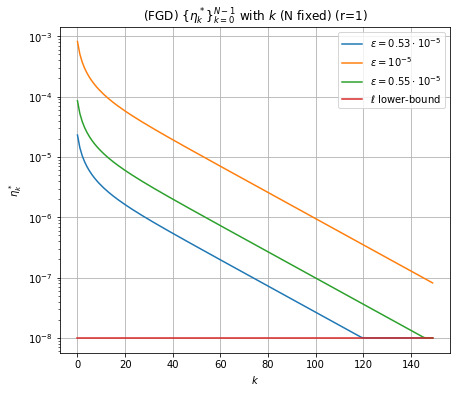

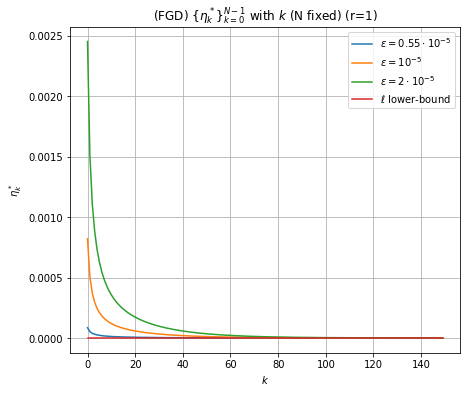

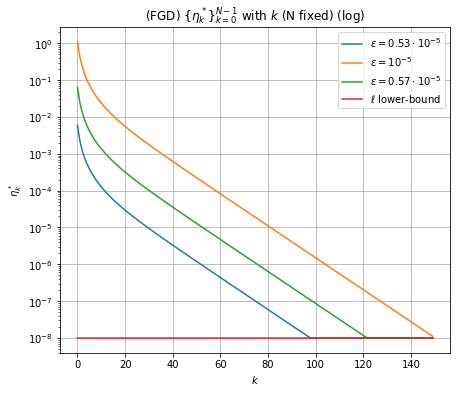

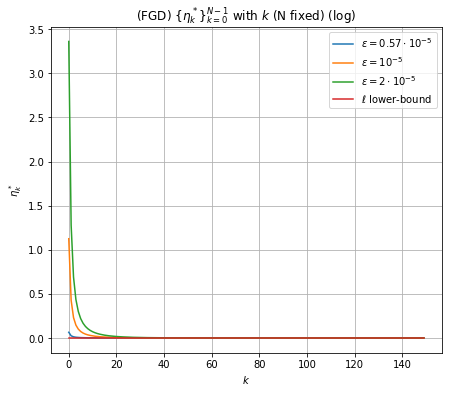

In [22]:

opt_etas,opt_cost_N = KKT_i(N=N_test,L=L_test,mu=mu_test,mode=mode_test,epsilon=epsilon_test,r=r_test,l=l_test)
opt_etas2,opt_cost_N2 = KKT_i(N=N_test,L=L_test,mu=mu_test,mode=mode_test,epsilon=epsilon_test2,r=r_test,l=l_test)
opt_etas3,opt_cost_N3 = KKT_i(N=N_test,L=L_test,mu=mu_test,mode=mode_test,epsilon=epsilon_test3,r=r_test,l=l_test)
opt_etashard,opt_cost_Nhard = KKT_i(N=N_test,L=L_test,mu=mu_test,mode=mode_test,epsilon=epsilon_hard,r=r_test,l=l_test)


if r_test==1:
    plt.figure(figsize=(7,6))
    if mode_test=='GD':
        plt.title('(GD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (r=1)')
    else:
        plt.title('(FGD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (r=1)')
    plt.xlabel('$k$')
    plt.ylabel('$\eta_k^*$')
    plt.grid()
    plt.semilogy(np.arange(N_test),opt_etashard)
    plt.semilogy(np.arange(N_test),opt_etas2)
    plt.semilogy(np.arange(N_test),opt_etas)
    plt.semilogy(np.arange(N_test),l_test*np.ones(N_test))
    if mode_test=='GD':
        plt.legend(['$\epsilon=10^{-5}$','$\epsilon=10^{-4}$','$\epsilon = 1.5 \cdot 10^{-5}$','$\ell$ lower-bound']);
    else:
        plt.legend(['$\epsilon=0.53 \cdot 10^{-5}$','$\epsilon=10^{-5}$','$\epsilon = 0.55 \cdot 10^{-5}$','$\ell$ lower-bound']);
    plt.savefig(str(mode_test)+'etas_log_'+str(r_test)+'.pdf')
    plt.savefig(str(mode_test)+'etas_log_'+str(r_test)+'.svg')

    plt.figure(figsize=(7,6))
    if mode_test=='GD':
        plt.title('(GD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (r=1)')
    else:
        plt.title('(FGD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (r=1)')
    plt.xlabel('$k$')
    plt.ylabel('$\eta_k^*$')
    plt.grid()
    plt.plot(np.arange(N_test),opt_etas)
    plt.plot(np.arange(N_test),opt_etas2)
    plt.plot(np.arange(N_test),opt_etas3)
    plt.plot(np.arange(N_test),l_test*np.ones(N_test))
    if mode_test=='GD':
        plt.legend(['$\epsilon=1.5\cdot 10^{-5}$','$\epsilon=10^{-4}$','$\epsilon = 2\cdot 10^{-4}$','$\ell$ lower-bound']);
    else:
        plt.legend(['$\epsilon=0.55\cdot 10^{-5}$','$\epsilon=10^{-5}$','$\epsilon = 2\cdot 10^{-5}$','$\ell$ lower-bound']);
    plt.savefig(str(mode_test)+'etas_lin_'+str(r_test)+'.pdf')
    
elif r_test==0.5:
    plt.figure(figsize=(7,6))
    if mode_test=='GD':
        plt.title('(GD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (r=1/2)')
    else:
        plt.title('(FGD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (r=1/2)')    
    plt.xlabel('$k$')
    plt.ylabel('$\eta_k^*$')
    plt.grid()
    plt.semilogy(np.arange(N_test),opt_etashard)
    plt.semilogy(np.arange(N_test),opt_etas2)
    plt.semilogy(np.arange(N_test),opt_etas)
    plt.semilogy(np.arange(N_test),l_test*np.ones(N_test))
    if mode_test=='GD':
        plt.legend(['$\epsilon=10^{-5}$','$\epsilon=10^{-4}$','$\epsilon = 1.5 \cdot 10^{-5}$','$\ell$ lower-bound']);
    else:
        plt.legend(['$\epsilon=0.53 \cdot 10^{-5}$','$\epsilon=10^{-5}$','$\epsilon = 0.55 \cdot 10^{-5}$','$\ell$ lower-bound']);
    plt.savefig(str(mode_test)+'etas_log_'+str(r_test)+'.pdf')

    plt.figure(figsize=(7,6))
    if mode_test=='GD':
        plt.title('(GD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (r=1/2)')
    else:
        plt.title('(FGD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (r=1/2)')    
    plt.xlabel('$k$')
    plt.ylabel('$\eta_k^*$')
    plt.grid()
    plt.plot(np.arange(N_test),opt_etas)
    plt.plot(np.arange(N_test),opt_etas2)
    plt.plot(np.arange(N_test),opt_etas3)
    plt.plot(np.arange(N_test),l_test*np.ones(N_test))
    if mode_test=='GD':
        plt.legend(['$\epsilon=1.5\cdot 10^{-5}$','$\epsilon=10^{-4}$','$\epsilon = 2\cdot 10^{-4}$','$\ell$ lower-bound']);
    else:
        plt.legend(['$\epsilon=0.55\cdot 10^{-5}$','$\epsilon=10^{-5}$','$\epsilon = 2\cdot 10^{-5}$','$\ell$ lower-bound']);
    plt.savefig(str(mode_test)+'etas_lin_'+str(r_test)+'.pdf')
    
    
    
opt_etas,opt_cost_N = KKT_ii(N=N_test,L=L_test,mu=mu_test,mode=mode_test,epsilon=epsilon_test,l=l_test)
opt_etas2,opt_cost_N2 = KKT_ii(N=N_test,L=L_test,mu=mu_test,mode=mode_test,epsilon=epsilon_test2,l=l_test)
opt_etas3,opt_cost_N3 = KKT_ii(N=N_test,L=L_test,mu=mu_test,mode=mode_test,epsilon=epsilon_test3,l=l_test)
opt_etashard,opt_cost_Nhard = KKT_ii(N=N_test,L=L_test,mu=mu_test,mode=mode_test,epsilon=epsilon_hard,l=l_test)



plt.figure(figsize=(7,6))
if mode_test=='GD':
    plt.title('(GD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (log)')
else:
    plt.title('(FGD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (log)')
plt.xlabel('$k$')
plt.ylabel('$\eta_k^*$')
plt.grid()
plt.semilogy(np.arange(N_test),opt_etashard)
plt.semilogy(np.arange(N_test),opt_etas2)
plt.semilogy(np.arange(N_test),opt_etas)
plt.semilogy(np.arange(N_test),l_test*np.ones(N_test))
if mode_test=='GD':
    plt.legend(['$\epsilon=10^{-5}$','$\epsilon=10^{-4}$','$\epsilon = 1.5 \cdot 10^{-5}$','$\ell$ lower-bound']);
else:
    plt.legend(['$\epsilon=0.53 \cdot 10^{-5}$','$\epsilon=10^{-5}$','$\epsilon = 0.57 \cdot 10^{-5}$','$\ell$ lower-bound']);
plt.savefig(str(mode_test)+'etas_log_log_1.pdf')

plt.figure(figsize=(7,6))
if mode_test=='GD':
    plt.title('(GD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (log)')
else:
    plt.title('(FGD) $\{\eta_k^*\}_{k=0}^{N-1}$ with $k$ (N fixed) (log)')
plt.xlabel('$k$')
plt.ylabel('$\eta_k^*$')
plt.grid()
plt.plot(np.arange(N_test),opt_etas)
plt.plot(np.arange(N_test),opt_etas2)
plt.plot(np.arange(N_test),opt_etas3)
plt.plot(np.arange(N_test),l_test*np.ones(N_test))
if mode_test=='GD':
    plt.legend(['$\epsilon=1.5\cdot 10^{-5}$','$\epsilon=10^{-4}$','$\epsilon = 2\cdot 10^{-4}$','$\ell$ lower-bound']);
else:
    plt.legend(['$\epsilon=0.57\cdot 10^{-5}$','$\epsilon=10^{-5}$','$\epsilon = 2\cdot 10^{-5}$','$\ell$ lower-bound']);
plt.savefig(str(mode_test)+'etas_lin_log_2.pdf')

In [25]:
# parameters of interest 

mode_test = 'FGD'

if mode_test=='GD':
    N_test=300 
    L_test= 10
    mu_test=0.1
    r_test= 2
    N_test_min = 700
    N_test_max = 4*N_test_min
    epsilon_test2 = 1e-4
    l_test = 2e-6
else:
    N_test = 150
    L_test = 10
    mu_test = 0.1
    #l_test = 1e-8
    l_test = 1e-15
    r_test = 1
    N_test_min = 55
    N_test_max = 6*N_test_min
    epsilon_test2 = 1e-3
    R_test = 1

GD not working don't know why...

iteration : 46
iteration : 96
iteration : 146
iteration : 196
iteration : 246


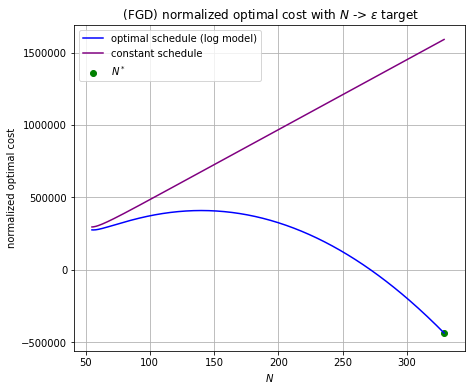

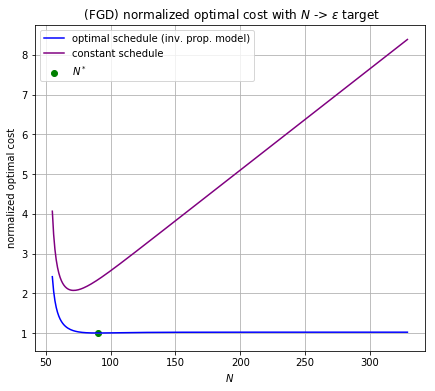

In [27]:
verbose = True

behavior_i = []
behavior_nul_i = []
behavior_const_i = []
#behavior_adap_i = []
behavior_ii = []
behavior_nul_ii = []
behavior_const_ii = []
#behavior_adap_ii = []

N_tests = np.arange(N_test_min,N_test_max)
for elem in N_tests:
    N_hat = int(elem)
    if verbose:
        if N_hat%50==0:
            print('iteration : '+str(int(1+N_hat-N_tests[0])))
    _,opt_cost_N2_i,nul_i,const_i = KKT_i(N=N_hat,L=L_test,mu=mu_test,mode=mode_test,epsilon=epsilon_test2,r=r_test,l=l_test,R=R_test,extr=True)
    _,opt_cost_N2_ii,nul_ii,const_ii= KKT_ii(N=N_hat,L=L_test,mu=mu_test,mode=mode_test,epsilon=epsilon_test2,l=l_test,R=R_test,j=2,extr=True)
    behavior_i.append(opt_cost_N2_i)
    behavior_ii.append(opt_cost_N2_ii)
    behavior_nul_i.append(nul_i)
    behavior_const_i.append(const_i)
    #behavior_adap_i.append(adap_i)
    behavior_nul_ii.append(nul_ii)
    behavior_const_ii.append(const_ii)
    #behavior_adap_ii.append(adap_ii)
be_i = np.array(behavior_i)
be_nul_i = np.array(behavior_nul_i)
be_const_i = np.array(behavior_const_i)
#be_adap_i = np.array(behavior_adap_i)
mini = np.min(be_i)
if mini>0:
    be_i = be_i / mini # normalization 
    be_nul_i = be_nul_i / mini
    be_const_i = be_const_i / mini
N_i_argmin = N_tests[np.argmin(be_i)]
#be_adap_i = be_adap_i/mini
be_ii = np.array(behavior_ii)
be_nul_ii = np.array(behavior_nul_ii)
be_const_ii = np.array(behavior_const_ii)
#be_adap_ii = np.array(behavior_adap_ii)
minii = np.min(be_ii)
if minii>0:
    be_ii = be_ii / minii # normalization
    be_nul_ii = be_nul_ii / minii
    be_const_ii = be_const_ii / minii
N_ii_argmin = N_tests[np.argmin(be_ii)]
#be_adap_ii = be_adap_ii / minii


# /!\ => change title in neg thing

plt.figure(figsize=(7,6))
if mode_test=='GD':
    plt.title(' (GD) normalized optimal cost with $N$ -> $\epsilon$ target')
else:
    plt.title(' (FGD) normalized optimal cost with $N$ -> $\epsilon$ target')
plt.xlabel('$N$')
plt.ylabel('normalized optimal cost')
plt.grid()
plt.plot(N_tests,be_ii,color='blue')
plt.plot(N_tests,be_const_ii,color='purple')
plt.scatter(N_ii_argmin,np.min(be_ii),color='green')
#plt.plot(N_tests,be_adap_ii)
plt.legend(['optimal schedule (log model)','constant schedule','$N^*$']) #,'constant schedule','constr. prop. schedule']);
plt.savefig(str(mode_test)+'_costs_log.pdf')
plt.savefig(str(mode_test)+'_costs_log.svg')

plt.figure(figsize=(7,6))
if mode_test=='GD':
    plt.title(' (GD) normalized optimal cost with $N$ -> $\epsilon$ target')
else:
    plt.title(' (FGD) normalized optimal cost with $N$ -> $\epsilon$ target')
plt.xlabel('$N$')
plt.ylabel('normalized optimal cost')
plt.plot(N_tests,be_i,color='blue')
plt.plot(N_tests,be_const_i,color='purple')
plt.grid()
#plt.plot(N_tests,be_adap_i)
plt.scatter(N_i_argmin,np.min(be_i),color='green')
plt.legend(['optimal schedule (inv. prop. model)','constant schedule','$N^*$']) #,'constant schedule','constr. prop. schedule']);
plt.savefig(str(mode_test)+'_costs_'+str(r_test)+'.pdf')
plt.savefig(str(mode_test)+'_costs_'+str(r_test)+'.svg')